In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import dragoman as dm
from scipy import stats
import scipy

In [3]:
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_openml

In [5]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [16]:
y = np.int32(y)

In [6]:
covX = np.cov(X.T)

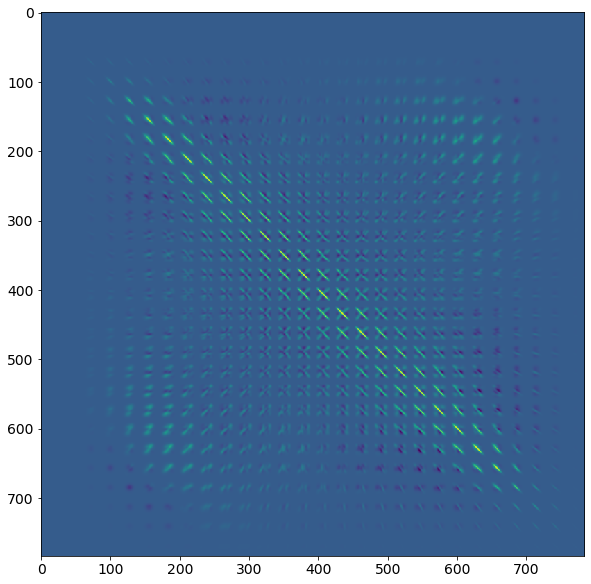

In [7]:
plt.imshow(covX)

In [9]:
w, v = np.linalg.eig(covX)

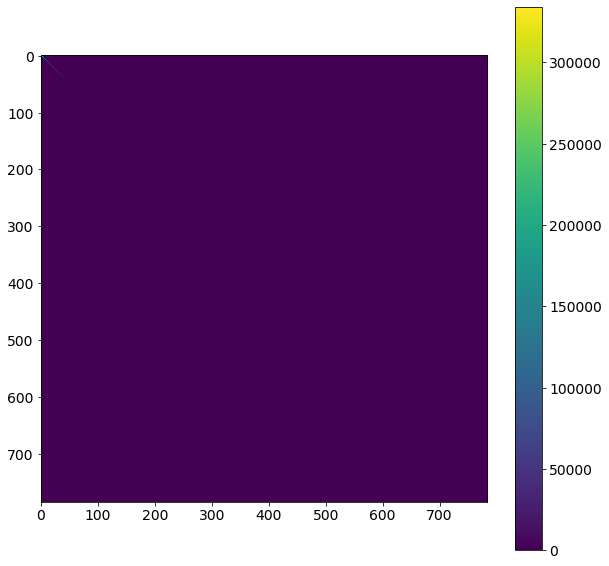

In [10]:
plt.imshow(v.real.T @ covX @ v.real)
plt.colorbar()

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

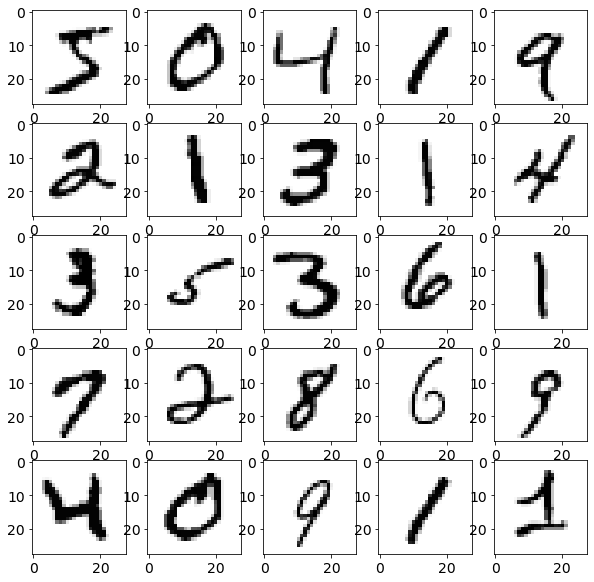

In [12]:
fig, ax = plt.subplots(5,5)
for i in range(25):
    axis = ax[i//5, i%5]
    axis.imshow(X[i].reshape(28,28), cmap='Greys')
#plt.savefig('mnist.png', bbox_inches='tight')

In [13]:
p = PCA(n_components=2)
p.fit_transform(X)
reduced_data = p.transform(X)
digits_rec = p.inverse_transform(reduced_data) #+ mean

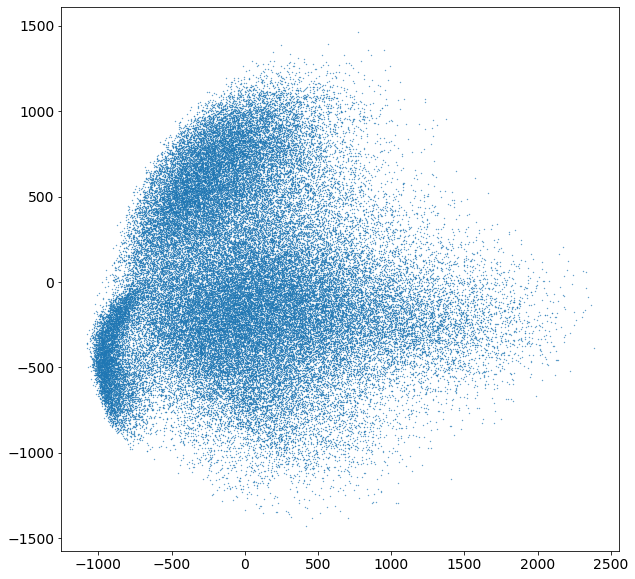

In [14]:
plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=0.1, cmap=plt.cm.get_cmap('Spectral', 10))

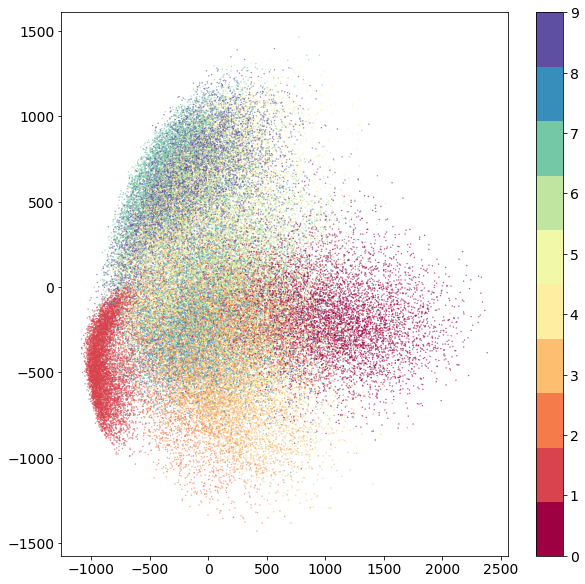

In [17]:
plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=0.1, c=y ,cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar()
#plt.savefig('mnist_true_labels.png', bbox_inches='tight')

In [18]:
cmap = 'winter'

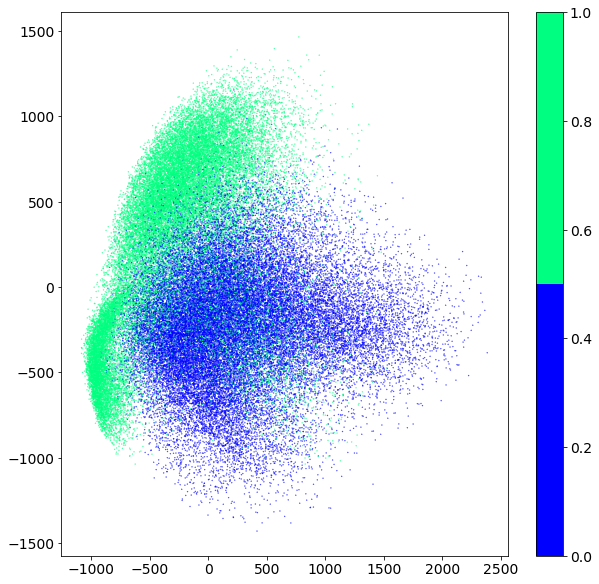

In [19]:
# do binary classification first

target = ((y == 1) | (y == 9) | (y == 5) | (y == 7) | (y == 4)).astype(np.float32)

plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=0.1, c=target ,cmap=plt.cm.get_cmap(cmap, 2))
plt.colorbar()
#plt.savefig('mnist_binary_labels.png', bbox_inches='tight')

In [20]:
X_train = reduced_data[:60000]
X_test = reduced_data[60000:]

In [22]:
y_train = target[:60000]
y_test = target[60000:]

In [23]:
fpr_test = {}
tpr_test = {}
fpr_train = {}
tpr_train = {}

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

In [25]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

In [26]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10, )
name = 'max. depth = %s'%clf.max_depth

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, max_depth=7) #DecisionTreeClassifier(max_depth=4))

In [28]:
#from sklearn.ensemble import RandomForestRegressor
#clf = RandomForestRegressor(n_estimators=20, max_depth=7, criterion='mse') #DecisionTreeClassifier(max_depth=4))

In [33]:
clf.fit(X_train, y_train, )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
y_predicted = clf.predict(X_train)
y_score = clf.predict(X_test)

In [35]:
y_predicted = clf.predict_proba(X_train)
y_score = clf.predict_proba(X_test)

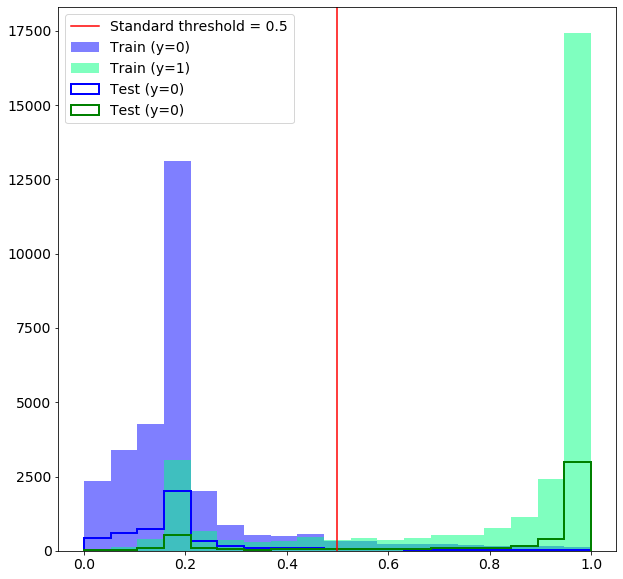

In [39]:
bins = np.linspace(0, 1, 20)
plt.hist(y_predicted[y_train==0][:,1], bins=bins, color=plt.cm.winter(0), label='Train (y=0)', alpha=0.5)
plt.hist(y_predicted[y_train==1][:,1], bins=bins, color=plt.cm.winter(1000), label='Train (y=1)', alpha=0.5)
plt.hist(y_score[y_test==0][:,1], bins=bins, color=plt.cm.winter(0), histtype='step', lw=2, label='Test (y=0)', hatch='77')
plt.hist(y_score[y_test==1][:,1], bins=bins, color='green', histtype='step', lw=2, label='Test (y=0)')
plt.axvline(0.5, color='red', label = 'Standard threshold = 0.5')
plt.legend()
#plt.savefig('DT_dist.png', bbox_inches='tight')

In [40]:
fpr_test[name], tpr_test[name], _ = roc_curve(y_test, y_score[:,1])
fpr_train[name], tpr_train[name], _ = roc_curve(y_train, y_predicted[:,1])

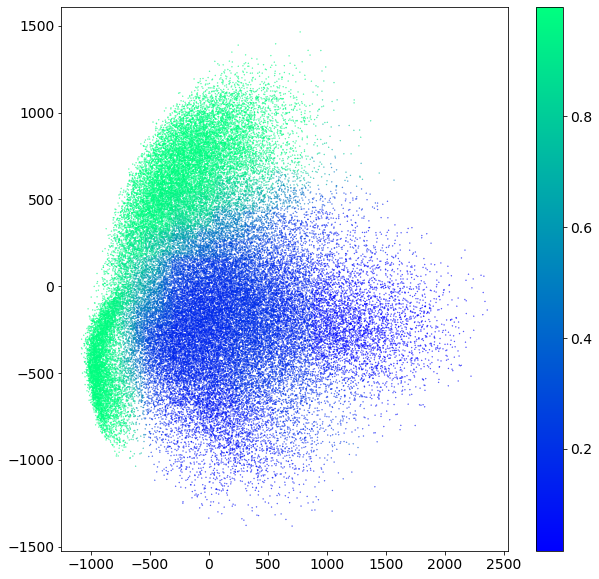

In [41]:
plt_data = plt.scatter(X_train[:, 0], X_train[:, 1], s=0.1, c=y_predicted[:,1] ,cmap=cmap)
plt.colorbar()
#plt.savefig('DT_proba.png', bbox_inches='tight')

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_score, )

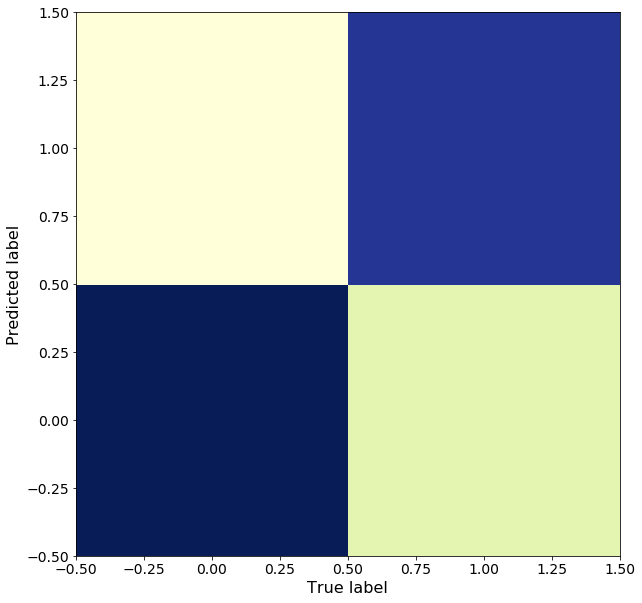

In [48]:
plt.imshow(cm.T, cmap='YlGnBu', origin='lower')
plt.gca().set_xlabel('True label')
plt.gca().set_ylabel('Predicted label')
plt.savefig('DT_confusion.png', bbox_inches='tight')

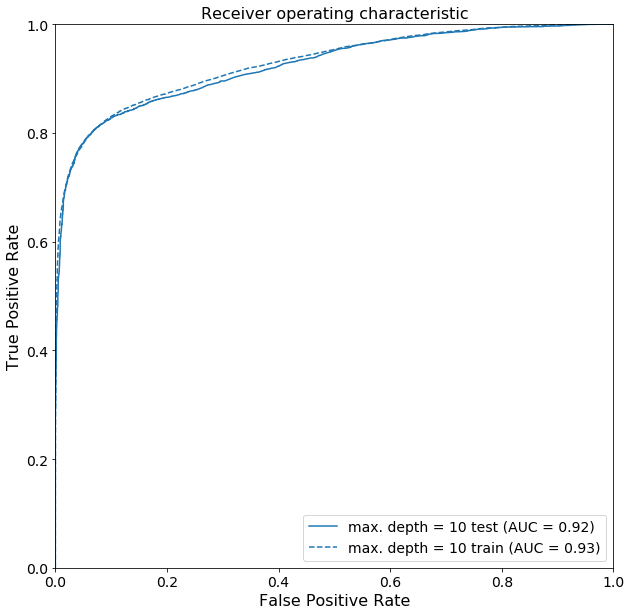

In [50]:
for key in tpr_test.keys():
    if key == 'max. depth = 50': continue
    bl = plt.plot(fpr_test[key], tpr_test[key], ls='-', label='%s test (AUC = %0.2f)' %(key,auc(fpr_test[key], tpr_test[key])))
    plt.plot(fpr_train[key], tpr_train[key], ls='--', c=bl[0].get_color(), label='%s train (AUC = %0.2f)' %(key, auc(fpr_train[key], tpr_train[key])))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('overtraining.png', bbox_inches='tight')

In [51]:
y_test_predicted_labels = clf.predict(X_test)

Text(0.5, 0.98, 'Class: 1, 4, 5, 7, 9')

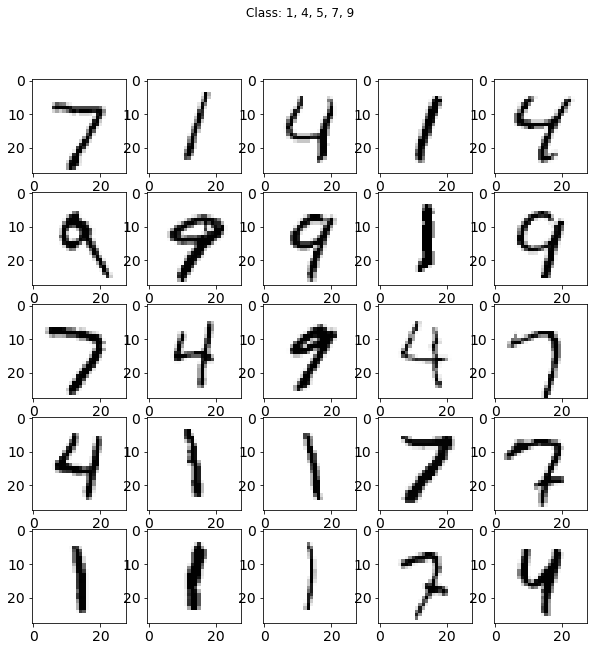

In [52]:
X_plot = X[60000:]

mask = y_test_predicted_labels == 1

fig, ax = plt.subplots(5,5)
for i in range(25):
    axis = ax[i//5, i%5]
    axis.imshow(X_plot[mask][i].reshape(28,28), cmap='Greys')
    
    
plt.suptitle('Class: 1, 4, 5, 7, 9')
#plt.suptitle('Class: 0, 2, 3, 6, 8')
    
#plt.savefig('mnist.png', bbox_inches='tight')

# Regression

In [53]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
print(boston_dataset['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [56]:
X_train, X_test, y_train, y_test = train_test_split(boston_dataset['data'], boston_dataset['target'], test_size = 0.2, random_state=5)

In [65]:
from tensorflow import keras

inputs = keras.Input(shape=(X_train.shape[1],))
h = keras.layers.Dense(32, activation="relu")(inputs)
outputs = keras.layers.Dense(1, activation='linear')(h)
reg = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(0.01)

reg.compile(loss='mse',
                optimizer=optimizer,
                )

In [58]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [70]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', max_iter=1000, tol=0.000001)

In [83]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=20, max_depth=4, criterion='mse')

In [84]:
reg.fit(X_train, y_train) #, epochs=50, verbose=0, )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

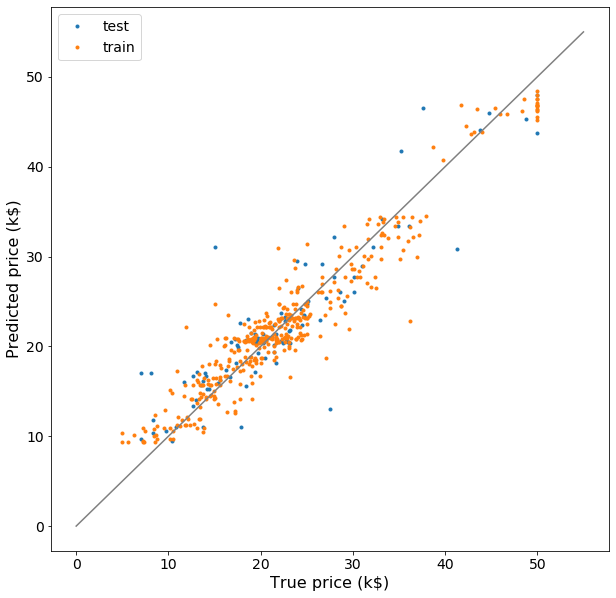

In [85]:
plt.plot(y_test, reg.predict(X_test), '.', label='test')
plt.plot(y_train, reg.predict(X_train), '.', label='train')
plt.plot([0,55], [0,55], c='grey')
plt.gca().set_xlabel('True price (k$)')
plt.gca().set_ylabel('Predicted price (k$)')
plt.legend()
plt.savefig('boston_DT.png', bbox_inches='tight')

In [86]:
import eli5
from eli5.sklearn import PermutationImportance


In [87]:
boston_dataset['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [88]:
perm = PermutationImportance(reg, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = boston_dataset['feature_names'])

Weight,Feature
0.7179 ± 0.0959,LSTAT
0.5301 ± 0.0586,RM
0.1332 ± 0.0372,DIS
0.0725 ± 0.0114,CRIM
0.0096 ± 0.0026,RAD
0.0076 ± 0.0015,PTRATIO
0.0075 ± 0.0012,NOX
0.0056 ± 0.0013,AGE
0.0015 ± 0.0010,B
0.0014 ± 0.0006,INDUS


In [89]:
import shap

In [90]:
shap.initjs()

In [91]:
X,y = shap.datasets.boston()

In [92]:
explainer = shap.TreeExplainer(reg)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [93]:
shap_values = explainer.shap_values(X)

In [94]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [95]:
shap.force_plot(explainer.expected_value, shap_values, X)

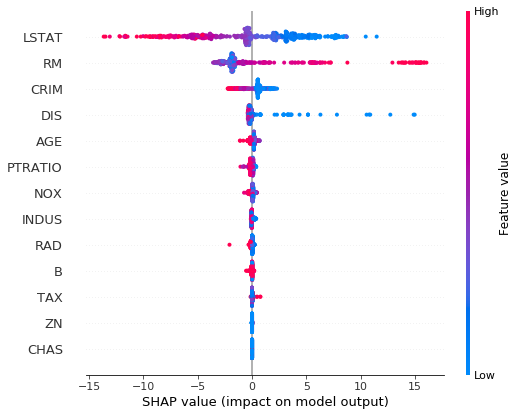

In [96]:
shap.summary_plot(shap_values, X)

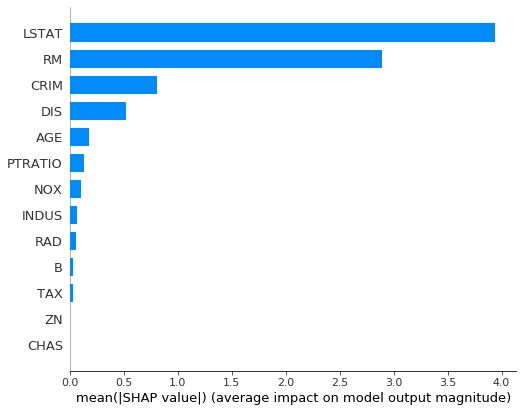

In [97]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [98]:
#np.mean(np.square(reg.predict(X_test)[:,0] - y_test))
np.mean(np.square(reg.predict(X_test) - y_test))

14.18147789477021

In [99]:
#np.mean(np.square(reg.predict(X_train)[:,0] - y_train))
np.mean(np.square(reg.predict(X_train) - y_train))

7.375596955815536